原始类型： <class 'numpy.ndarray'>
图像形状： (561, 728, 3)
像素范围： 0 ~ 255


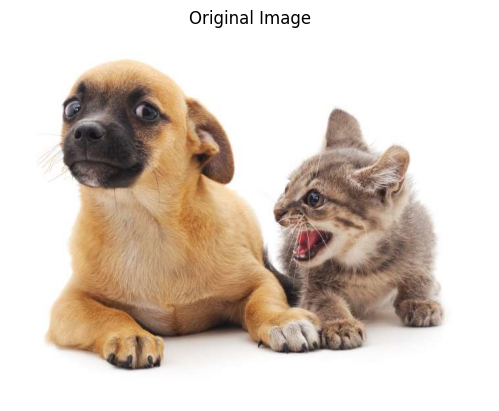

转换后的 Tensor 形状： torch.Size([3, 224, 224])


In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# 1️⃣ 设置图片路径（确保存在）
img_path = '../asset/catdog.jpg'

# 2️⃣ 加载图像（返回 ndarray，范围为 [0,1]，形状: H x W x C）
img = plt.imread(img_path)

# 3️⃣ 打印图像信息
print("原始类型：", type(img))
print("图像形状：", img.shape)
print("像素范围：", img.min(), "~", img.max())

# 4️⃣ 显示原图
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴
plt.title('Original Image')
plt.show()

# 5️⃣ 如果你想把它转换成 Tensor 并 resize 到 224×224（适用于 VGG / ResNet）
transform = transforms.Compose([
    transforms.ToPILImage(),                 # ndarray 转为 PIL Image
    transforms.Resize((224, 224)),          # 调整大小
    transforms.ToTensor(),                  # 转为 Tensor，范围变为 [0,1] 且顺序变为 (C,H,W)
])

img_tensor = transform(img)
print("转换后的 Tensor 形状：", img_tensor.shape)  # 应该是 (3, 224, 224)


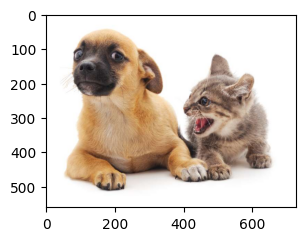

In [2]:
import torch
from matplotlib import pyplot as plt
from ml_model_utils import *

set_figsize()
img_path = '../asset/catdog.jpg'
img = plt.imread(img_path)
plt.imshow(img)

In [4]:
def box_corner_to_center(boxes):
    """
    将边界框从 (x1, y1, x2, y2) 转换为 (cx, cy, w, h)
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """
    将边界框从 (cx, cy, w, h) 转换为 (x1, y1, x2, y2)
    """
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes


In [5]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes))


tensor([[ 60.,  45., 378., 516.],
        [400., 112., 655., 493.]])

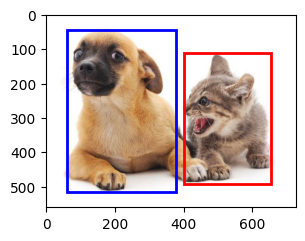

In [6]:
def bbox_to_rect(bbox, color):
    """
    将边界框 (x1, y1, x2, y2) 转换为 matplotlib 的 Rectangle 对象。

    参数:
    - bbox: 长度为4的列表 [x1, y1, x2, y2]
    - color: 边框颜色（字符串，如 'red', 'blue'）

    返回:
    - matplotlib.patches.Rectangle 对象
    """
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]),                        # 左上角 (x1, y1)
        width=bbox[2] - bbox[0],                      # 宽 = x2 - x1
        height=bbox[3] - bbox[1],                     # 高 = y2 - y1
        fill=False,                                   # 不填充颜色
        edgecolor=color, linewidth=2                  # 边框颜色和粗细
    )


fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(bbox_to_rect(dog_bbox, 'blue'))
ax.add_patch(bbox_to_rect(cat_bbox, 'red'))
plt.show()


In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # 获取图像和 mask 文件路径
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))


    def __getitem__(self, idx):
        # 加载图像和其对应的 mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])


        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # 将 mask 转换为 numpy 数组
        mask = np.array(mask)

        # 找出 mask 中的所有对象 ID（去除背景 0）
        obj_ids = np.unique(mask)[1:]

        boxes = []
        for obj_id in obj_ids:
            # 获取当前对象在 mask 中的位置
            pos = np.where(mask == obj_id)
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 转为 PyTorch 张量
        # boxes 是一个形状为 [N, 4] 的数组，每一行代表一个边界框 [xmin, ymin, xmax, ymax]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # 为每一个目标分配类别标签。这里假设所有目标都是“行人”，用类别 1 表示
        # 因此创建一个形状为 [N] 的张量，全为 1，数据类型为 int64（Faster R-CNN 要求）
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # 所有对象类别都为“1”：行人

        # 为当前图像分配一个唯一 ID，通常用于区分不同图像。这里使用索引 idx 构造一个张量
        image_id = torch.tensor([idx])

        # 计算每个边界框的面积：宽度 × 高度
        # (xmax - xmin) * (ymax - ymin)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        # 指示每个目标是否为“群体”目标（iscrowd），通常用于 COCO 评估中
        # 这里设置为 0，表示每个目标都是独立的，不属于人群等难以分割的群体
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # 构建目标信息字典
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # 如果定义了 transforms（如 ToTensor）
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


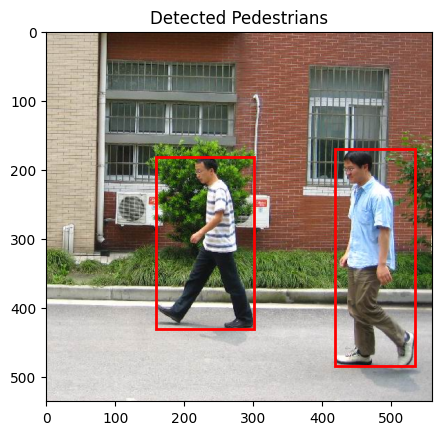

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor

# 创建数据集对象
dataset = PennFudanDataset("PennFudanPed", transforms=ToTensor())

# 取出第 0 个样本
img, target = dataset[0]

# 显示图像
fig, ax = plt.subplots(1)
ax.imshow(img.permute(1, 2, 0))  # 将 CHW 转为 HWC

# 绘制目标框
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title("Detected Pedestrians")
plt.show()
